In [7]:
import torch
import train
import model
import numpy as np
import csvLoader as cl
import visualizer as vs
import dataLoader as dl
import dataAugmentation as da
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

GPU mode: True
Len of train csv: 7049
Loading Dataset...
Randomly Visualizing...


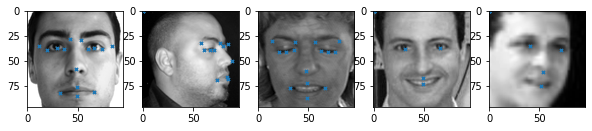

In [8]:
TRAIN_CSV_PATH = 'facial-keypoints-detection/training/training.csv'
TEST_CSV_PATH = 'facial-keypoints-detection/test/test.csv'

USE_GPU, device = train.check_GPU()
print('GPU mode: {}'.format(USE_GPU))

train_csv = cl.load_csv(TRAIN_CSV_PATH)

print(f'Len of train csv: {len(np.array(train_csv.Image))}')
csv_allValid, csv_autoFill, csv_missingOnly = cl.clean_csv(train_csv)

print('Loading Dataset...')
autoFill_dataset = dl.FacialKptsDataSet(csv_autoFill)
print('Randomly Visualizing...')
vs.rand_vis_dataset(autoFill_dataset, 5)

In [9]:
autoFillTrain, autoFillVal = dl.getTrainValidationDataSet(csv_autoFill, 0.85)
print('Loading training/val set...')
train_dataset = dl.FacialKptsDataSet(autoFillTrain)
val_dataset = dl.FacialKptsDataSet(autoFillVal)

Loading training/val set...


Visualizing dataset #0...


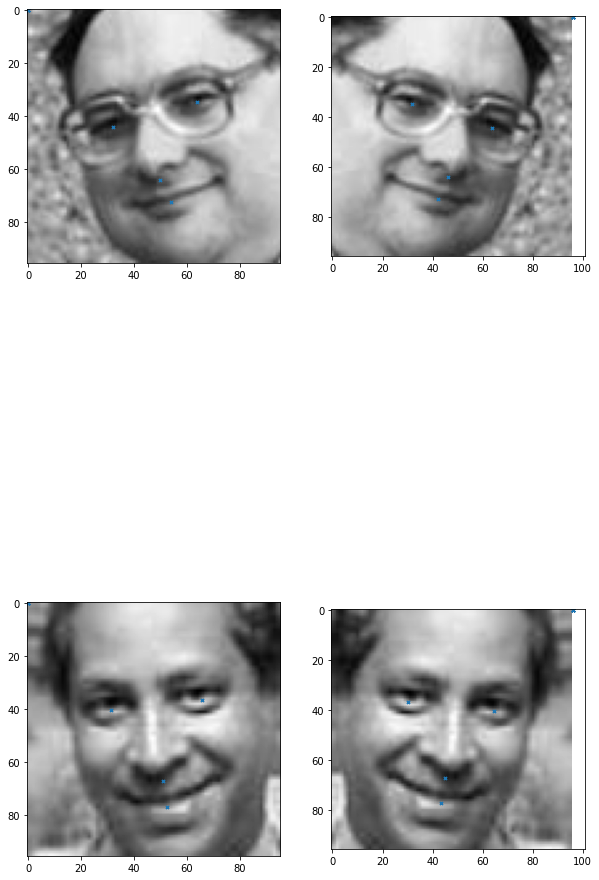

Size of Original set - 7049
Size of Mirror Aug sets list - 1


In [10]:
# Mirror
mirror_set = da.create_augs_from_transform(autoFillTrain, da.mirror, params=[None])
vs.rand_vis_compare_orig_augset(train_dataset, mirror_set, 2)
print('Size of Original set - {}\nSize of Mirror Aug sets list - {}'.format(len(autoFill_dataset), len(mirror_set)))

Visualizing dataset #0...
Visualizing dataset #1...


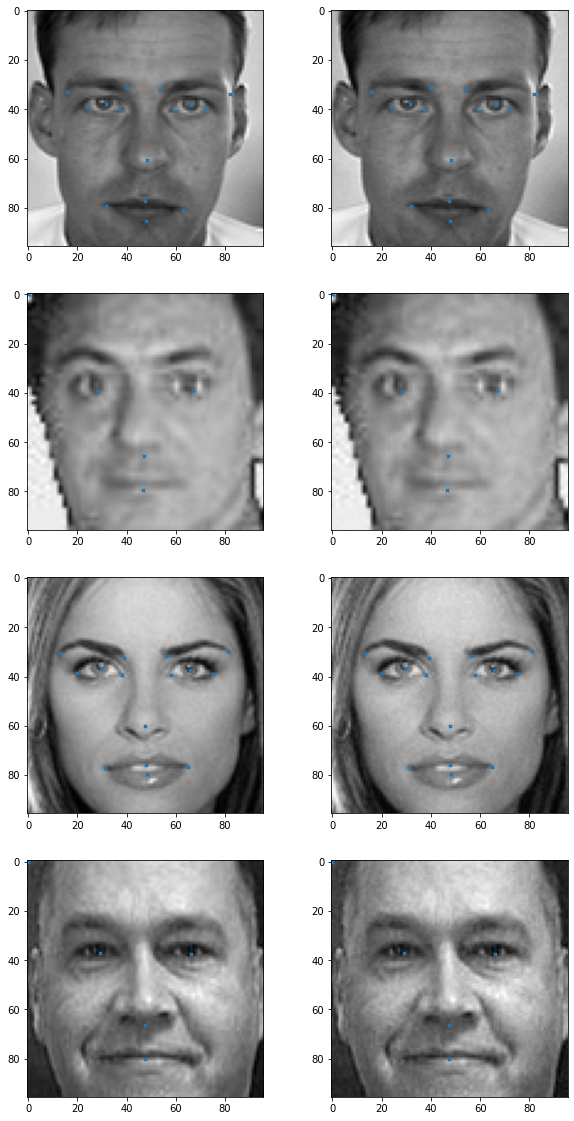

In [11]:
# Add Noise
noise_set = da.create_augs_from_transform(autoFillTrain, da.add_noise, params=[0.008, 0.02])
vs.rand_vis_compare_orig_augset(train_dataset, noise_set, 2)

Visualizing dataset #0...
Visualizing dataset #1...
Visualizing dataset #2...
Visualizing dataset #3...


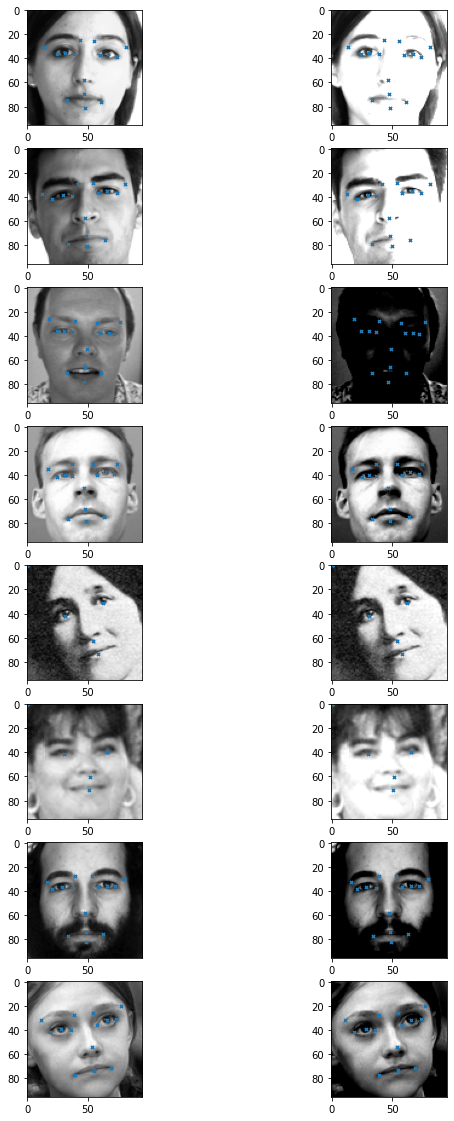

In [13]:
# Brightness Trim
brightTrim_set = da.create_augs_from_transform(autoFillTrain, da.brightness_trim, params=[1, -1, 0.5, -0.5])
vs.rand_vis_compare_orig_augset(train_dataset, brightTrim_set, 2)

Visualizing dataset #0...
Visualizing dataset #1...
Visualizing dataset #2...
Visualizing dataset #3...


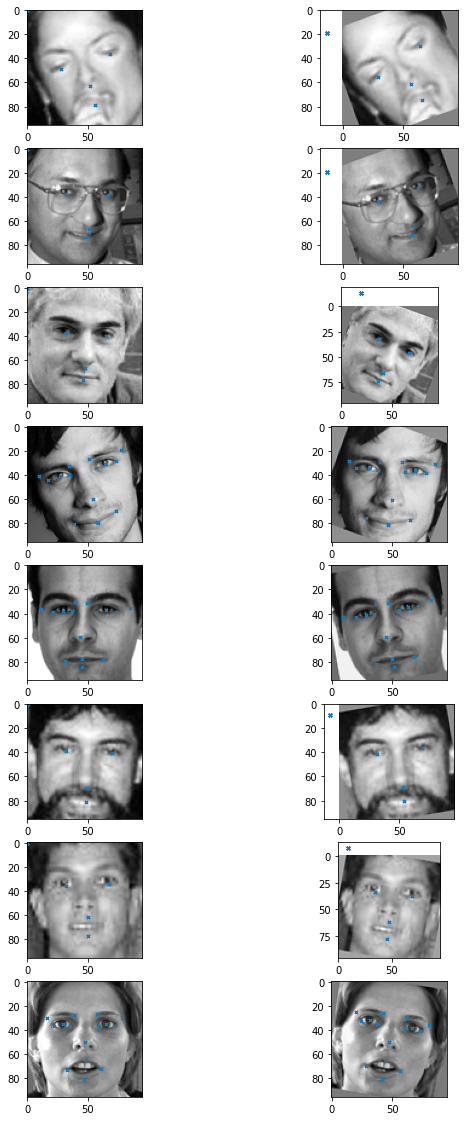

In [14]:
# Rotation
rotation_set = da.create_augs_from_transform(autoFillTrain, da.rotate, params=[20, -20, 10, -10])
vs.rand_vis_compare_orig_augset(train_dataset, rotation_set, 2)

In [27]:
all_datasets = []

all_datasets += [train_dataset]
all_datasets += mirror_set
all_datasets += noise_set
all_datasets += brightTrim_set
all_datasets += rotation_set

print('Num of datasets after augmentation: {}'.format(len(all_datasets)))

print('Concatenating all sets...')
train_datasets = torch.utils.data.ConcatDataset(all_datasets)
print('Num of samples after concatenation: {}'.format(len(train_datasets)))

Num of datasets after augmentation: 12
Concatenating all sets...
Num of samples after concatenation: 71892


In [28]:
# Init samplers and loaders
train_sampler = SubsetRandomSampler(range(len(train_datasets)))
val_sampler = SubsetRandomSampler(range(len(val_dataset)))

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=150, sampler=train_sampler, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=150, sampler=val_sampler, num_workers=4)

print('Size of training loader batches: {}\nSize of validation loader batches: {}'.format(len(train_loader), len(val_loader)))

Size of training loader batches: 480
Size of validation loader batches: 8


In [29]:
# Nets
fc_model = model.FullyConnectedNet()
resnet32_model = model.resnet32()
resnet47_model = model.resnet47()

In [32]:
# Optimizer and scheduler Inits
lr = 2e-2
optimizer = optim.Adam(resnet47_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=5)

In [ ]:
train.train_model(resnet47_model, optimizer, train_loader, val_loader, scheduler=scheduler, loss_fn=train.RMSELoss, to_mask=True, epochs=50)

Using Device - cuda
Starting Epoch: 1/50 
